# Filtering Goodreads Reviews

During data exploration, a number of issues with the reviews have come to the surface that require some form of data *cleaning*, i.e. *selection* and *normalization* of reviews.

This notebook shows the cleaning steps that were taken.

### Non-Reviews

A plot of the review length distribution revealed that there are a few lengths (in number of characters) with high peaks in the frequency distribution. E.g. there are many more reviews of length 3 than expected given the rest of the distribution. Inspection revealed that many of those 3-character reviews contain only a rating, like '3.5' or '4.5'.

Another peak occurs at length 40: there is a large number of reviews that are only a URL for a webpage that contains the actual review. Goodreads shortens longer URLs to 40 characters in the anchor text of an HTML `<a>` element for display, with the full URL in the anchor `href` attribute. There are 30,277 such reviews. 

Types of non-reviews:

- length 0: these are empty reviews, which are no reviews at all. There is no review content.
- length 3: these are mainly reviews that only mention a rating, like '3.5' or '4.5'. 
- length 9-12: these are mainly reviews that only mention a rating followed by the word 'stars', like '3.5 stars' or '4.5 stars'.
- length 40: there is a large number of reviews that are only a URL for a webpage that contains the actual review. Goodreads shortens longer URLs to 40 characters in the anchor text of an HTML `<a>` element for display, with the full URL in the anchor `href` attribute. There are 30,277 such reviews. 



The steps below are taken with the aim to remove these so-called *non-reviews*:

In [1]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2

# This is needed to add the repo dir to the path so jupyter
# can load the modules in the scripts directory from the notebooks
import os
import sys
repo_dir = os.path.split(os.getcwd())[0]
print(repo_dir)
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    
import numpy as np
import pandas as pd
import json
import csv
from collections import Counter
import gzip
import os

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'

author_file = os.path.join(data_dir, 'goodreads_book_authors.csv.gz') # author information
book_file = os.path.join(data_dir, 'goodreads_books.csv.gz') # basic book metadata
genre_file = os.path.join(data_dir, 'goodreads_book_genres_initial.csv.gz') # book genre information
review_file = os.path.join(data_dir, 'goodreads_reviews_dedup-no_text.csv.gz') # excludes text to save memory
review_text_file = os.path.join(data_dir, 'goodreads_reviews_dedup.csv.gz') # includes text



/Users/marijnkoolen/Code/Huygens/scale


In [2]:
review_df = pd.read_csv(review_file, sep='\t', compression='gzip')

review_df


,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0,968
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,2086
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0,474
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4,962
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0,420
...,...,...,...,...,...,...,...,...,...,...,...
15739962,d0f6d1a4edcab80a6010cfcfeda4999f,1656001,b3d9a00405f7e96752d67b85deda4c7d,4,Mon Jun 04 18:08:44 -0700 2012,Tue Jun 26 18:58:46 -0700 2012,NaN,Sun Jun 10 00:00:00 -0700 2012,0,1,299
15739963,594c86711bd7acdaf655d102df52a9cb,10024429,2bcba3579aa1d728e664de293e16aacf,5,Fri Aug 01 18:46:18 -0700 2014,Fri Aug 01 18:47:07 -0700 2014,NaN,NaN,0,0,71
15739964,594c86711bd7acdaf655d102df52a9cb,6721437,7c1a7fcc2614a1a2a29213c11c991083,3,Tue Aug 27 12:49:25 -0700 2013,Tue Aug 27 12:53:46 -0700 2013,NaN,NaN,0,0,224
15739965,594c86711bd7acdaf655d102df52a9cb,15788197,74a9f9d1db09a90aae3a5acea68c6593,2,Fri May 03 13:06:15 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 00:00:00 -0700 2013,0,0,108


<AxesSubplot:>

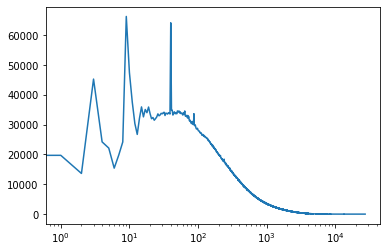

In [5]:
review_df.review_length.value_counts().sort_index().plot(logx=True)

In [4]:
review_df[review_df.review_length < 50].review_length.value_counts().sort_index()

0      6938
1     19717
2     13640
3     45288
4     24220
5     22144
6     15422
7     19845
8     24205
9     66297
10    47467
11    37583
12    30385
13    26734
14    32114
15    35955
16    32618
17    35097
18    34022
19    35913
20    33675
21    31992
22    32401
23    31484
24    32009
25    32592
26    33616
27    32977
28    33254
29    33810
30    33634
31    33967
32    34169
33    33071
34    33903
35    33726
36    33558
37    34014
38    33884
39    33581
40    64165
41    34872
42    34845
43    33229
44    33592
45    34321
46    34057
47    33651
48    33981
49    33656
Name: review_length, dtype: int64

The following steps check individual reviews for characteristics of non-reviews and create a derived review file with the identified non-reviews removed.


In [ ]:
# helper is a module with simple helper functions
from helper import read_csv
from collections import Counter
import re

def is_url(record):
    return record['review_length'] <= 40 and record['review_text'].startswith('http')
    
def is_rating(record):
    if record['review_length'] > 12:
        return False
    if record['review_length'] < 4 and re.search(r'\d', record['review_text']):
        return True
    for word in ['star', 'stars', 'sterne', 'ster', 'sterren', 'rating']:
        if re.search(word, record['review_text'], re.IGNORECASE) and re.search(r'\d', record['review_text']):
            return True
    return False

def is_date(record):
    if record['review_length'] > 12:
        return False
    if re.search(r'20\d{,2}', record['review_text']):
        return True
    return False

def is_empty(record):
    return record['review_length'] == 0

def is_non_review(record):
    if record['review_length'] > 40:
        return False
    return is_empty(record) or is_url(record) or is_rating(record) or is_date(record)



In [37]:
review_filtered_file = os.path.join(data_dir, 'goodreads_reviews_dedup_filtered-no_text.csv.gz') # excludes text and non-reviews


headers = [
    'user_id', 'book_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 
    'started_at', 'n_votes', 'n_comments', 'review_length', 'review_text'
]

with gzip.open(filtered_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    for ri, record in enumerate(read_csv(review_text_file)):
        record['review_length'] = int(record['review_length'])
        if is_non_review(record):
            continue
        row = [record[header] for header in headers]
        writer.writerow(row)
        if (ri+1) % 1000000 == 0:
            print(ri+1, 'records parsed')

print(ri+1, 'records parsed')


/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/goodreads_reviews_dedup_filtered.csv.gz
1000000 records parsed
2000000 records parsed
3000000 records parsed
4000000 records parsed
5000000 records parsed
6000000 records parsed
7000000 records parsed
8000000 records parsed
9000000 records parsed
10000000 records parsed
11000000 records parsed
12000000 records parsed
13000000 records parsed
14000000 records parsed
15000000 records parsed
15739967 records parsed


In [3]:
# the filtered review file excludes text and non-reviews
review_filtered_file = os.path.join(data_dir, 'goodreads_reviews_dedup_filtered-no_text.csv.gz') 

review_df = pd.read_csv(review_filtered_file, sep='\t', compression='gzip')

review_df


,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0,968
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,2086
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0,474
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4,962
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0,420
...,...,...,...,...,...,...,...,...,...,...,...
15616192,d0f6d1a4edcab80a6010cfcfeda4999f,1656001,b3d9a00405f7e96752d67b85deda4c7d,4,Mon Jun 04 18:08:44 -0700 2012,Tue Jun 26 18:58:46 -0700 2012,NaN,Sun Jun 10 00:00:00 -0700 2012,0,1,299
15616193,594c86711bd7acdaf655d102df52a9cb,10024429,2bcba3579aa1d728e664de293e16aacf,5,Fri Aug 01 18:46:18 -0700 2014,Fri Aug 01 18:47:07 -0700 2014,NaN,NaN,0,0,71
15616194,594c86711bd7acdaf655d102df52a9cb,6721437,7c1a7fcc2614a1a2a29213c11c991083,3,Tue Aug 27 12:49:25 -0700 2013,Tue Aug 27 12:53:46 -0700 2013,NaN,NaN,0,0,224
15616195,594c86711bd7acdaf655d102df52a9cb,15788197,74a9f9d1db09a90aae3a5acea68c6593,2,Fri May 03 13:06:15 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 00:00:00 -0700 2013,0,0,108


In [ ]:
from dateutil.parser import parse, tz

def parse_date(date_str):
    try:
        return parse(date_str).astimezone(utc)
    except TypeError:
        return None

utc = tz.gettz('UTC')

#book_df = pd.read_csv(book_file, sep='\t', compression='gzip')

#book_df[['book_id', 'work_id']]
#review_df = pd.merge(review_df, book_df[['book_id', 'work_id']], on='book_id', how='left')

review_df['date_added'] = review_df.date_added.apply(parse_date)
review_df['date_updated'] = review_df.date_updated.apply(parse_date)
review_df['read_at'] = review_df.read_at.apply(parse_date)
review_df['started_at'] = review_df.started_at.apply(parse_date)

review_df.columns

In [ ]:
review_df.to_csv(review_filtered_file, sep='\t', compression='gzip')
    
#review_df = pd.read_csv(review_filtered_file, sep='\t', compression='gzip')


### Making review subsets for content analysis

The entire Goodreads review collection including all the review text is too big to read into a dataframe, so we create a number of sample review subsets with text included that will be used for content analysis.

The following criteria will be used to analyse various aspects of scale:

- all reviews of frequently reviewed books (repetition across reviews as book characteristics)
- all reviews of frequent reviewers (repetition across reviews as reviewer characteristics)
- random sample of reviews (repetition across reviews as book review characteristics)


In [38]:
counts = review_df.book_id.value_counts()

threshold = 10000
books_above_10k = [str(book_id) for book_id, count in counts[counts > threshold].iteritems()]
print(f'number of books with over {threshold} reviews:', len(counts[counts > threshold]))
print(f'number of reviews for books with over {threshold} reviews:', sum(counts[counts > threshold]))

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
sample_review_text_file = os.path.join(data_dir, 'goodreads_reviews-books_above_10k_reviews.csv.gz') # includes text

headers = [
    'user_id', 'book_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 'started_at', 
    'n_votes', 'n_comments', 'review_length', 'review_text'
]

with gzip.open(sample_review_text_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    for review in read_csv(review_text_file):
        if review['book_id'] not in books_above_10k:
            continue
        row = [review[header] for header in headers]
        writer.writerow(row)


number of books with over 10000 reviews: 9
number of reviews for books with over 10000 reviews: 121515
['11870085', '2767052', '7260188', '22557272', '6148028', '19063', '10818853', '13335037', '41865']


In [40]:
counts = review_df.user_id.value_counts()

threshold = 5000
users_above_5k = [user_id for user_id, count in counts[counts > threshold].iteritems()]
print(f'number of users with over {threshold} reviews:', len(counts[counts > threshold]))
print(f'number of reviews for users with over {threshold} reviews:', sum(counts[counts > threshold]))

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
sample_review_text_file = os.path.join(data_dir, 'goodreads_reviews-reviewers_above_5k_reviews.csv.gz') # includes text

headers = [
    'user_id', 'book_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 'started_at', 
    'n_votes', 'n_comments', 'review_length', 'review_text'
]

print(users_above_5k)

with gzip.open(sample_review_text_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    for review in read_csv(review_text_file):
        if review['user_id'] not in users_above_5k:
            continue
        row = [review[header] for header in headers]
        writer.writerow(row)


number of users with over 5000 reviews: 12
number of reviews for users with over 5000 reviews: 98208


['a2d6dd1685e5aa0a72c9410f8f55e056',
 '4922591667fd3e8adc0c5e3d42cf557a',
 '459a6c4decf925aedd08e45045c0d8c6',
 'dd9785b14664103617304996541ed77a',
 '9003d274774f4c47e62f77600b08ac1d',
 '843a44e2499ba9362b47a089b0b0ce75',
 'b7772313835ce6257a3fbe7ad2649a29',
 '795595616d3dbd81bd16b617c9a1fa48',
 '8bb031b637de69eba020a8a466d1110b',
 '8e7e5b546a63cb9add8431ee6914cf59',
 '6ac35fe952c608da50153d64f616291b',
 'a45fb5d39a6a9857ff8362900790510a']

In [56]:
data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
sample_review_text_file = os.path.join(data_dir, 'goodreads_reviews-random_sample_1M.csv.gz') # includes text

headers = [
    'user_id', 'book_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 'started_at', 
    'n_votes', 'n_comments', 'review_length', 'review_text'
]

threshold = 1000000
prob_threshold = threshold / len(review_df)

with gzip.open(sample_review_text_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    for review in read_csv(review_text_file):
        if np.random.rand() > prob_threshold:
            continue
        row = [review[header] for header in headers]
        writer.writerow(row)
